# APS360 — CROHME (InkML) → Offline HMER, End-to-End
**What this does:**
1) Download CROHME 2023 from Zenodo (InkML contains strokes + LaTeX)  
2) Parse InkML → extract LaTeX + render strokes to 256×256 PNG  
3) Auto-build a vocab + split into train/val/test  
4) Train LSTM decoder with Bahdanau attention + ResNet18 encoder  
5) Save checkpoints, qualitative grids, and an attention GIF  

**Note:** CROHME23.zip is ~1.8 GB. Make sure you have disk space. License: CC BY‑NC‑SA 3.0 (non‑commercial).

In [1]:

OUT_ROOT = "./crohme23_offline"
IMG_SIZE = 256
MAX_SAMPLES = None

# Training
SAVE_DIR = "./runs/crohme23_lstm"
BATCH_SIZE = 32
EPOCHS = 8
LR = 1e-4
LABEL_SMOOTH = 0.1
USE_AMP = True
ACCUM_STEPS = 2
TF_SCHEDULE = "cosine"
TF_START = 1.0
TF_END = 0.4
BEAM_SIZE = 1
COV_PENALTY = 0.0
DEMO_GRID_EVERY = 2
NUM_ROWS, NUM_COLS = 4, 4
SEED = 42


## Download CROHME 2023 (Zenodo)
Source: ICDAR 2023 CROHME dataset on Zenodo (contains online InkML and offline PNG; we will use **InkML** to render our own images).

In [2]:

import os, io, zipfile, math, random, json, shutil, sys, time
from pathlib import Path
import requests
from tqdm import tqdm

ZENODO_URL = "https://zenodo.org/records/8428035/files/CROHME23.zip?download=1"
RAW_DIR = Path("./_downloads")
RAW_DIR.mkdir(parents=True, exist_ok=True)
ZIP_PATH = RAW_DIR / "CROHME23.zip"

def download_with_progress(url, dest):
    if dest.exists() and dest.stat().st_size > 1_000_000:
        print("Found existing:", dest)
        return
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        pbar = tqdm(total=total, unit="B", unit_scale=True, desc="Downloading CROHME23.zip")
        with open(dest, "wb") as f:
            for chunk in r.iter_content(chunk_size=1<<20):
                if chunk:
                    f.write(chunk); pbar.update(len(chunk))
        pbar.close()

download_with_progress(ZENODO_URL, ZIP_PATH)

EXTRACT_DIR = RAW_DIR / "CROHME23"
if not EXTRACT_DIR.exists():
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(EXTRACT_DIR)
print("Extracted to:", EXTRACT_DIR)


Extracted to: _downloads/CROHME23


## Parse InkML → PNG + LaTeX
We will scan for `.inkml` files in the extracted archive, extract the LaTeX string from annotations, render strokes to 256×256 PNG, and write `labels.json`. If CROHME's structure changes, tweak the `find_inkml_files()` and `extract_latex()` helpers.

In [3]:

from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import numpy as np

INK_NS = "{http://www.w3.org/2003/InkML}"

def find_inkml_files(root: Path):
    return sorted([p for p in root.rglob("*.inkml")])

def extract_traces(inkml_path: Path):
    tree = ET.parse(inkml_path)
    root = tree.getroot()
    traces = []
    for tr in root.findall(f".//{INK_NS}trace"):
        raw = tr.text.strip() if tr.text else ""
        pts = []
        for token in raw.replace(",", " ").split():

            try:
                pts.append(float(token))
            except:
                pass

        pts = list(zip(pts[0::2], pts[1::2]))
        traces.append(pts)
    return traces, root

def extract_latex(root):

    latex = None
    for ann in root.findall(f".//{INK_NS}annotation"):
        t = (ann.attrib.get("type","") or "").lower()
        val = (ann.text or "").strip()
        if not val:
            continue
        if "latex" in t or t in {"truth", "label", "text"}:

            if ("\\" in val) or ("{" in val) or ("}" in val):
                latex = val
                break
            if latex is None:
                latex = val

    return latex

def render_traces(traces, size=256, margin=0.04):

    all_pts = [(x,y) for tr in traces for (x,y) in tr]
    if not all_pts:
        img = Image.new("L", (size,size), 255)
        return img
    xs, ys = zip(*all_pts)
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)

    w = maxx - minx if (maxx - minx) > 0 else 1.0
    h = maxy - miny if (maxy - miny) > 0 else 1.0
    scale = 1.0 / max(w, h)
    M = margin
    S = size

    SS = 4; S2 = S*SS
    img = Image.new("L", (S2, S2), 255)
    drw = ImageDraw.Draw(img)
    def norm(p):
        x = ((p[0]-minx)*scale)*(1-2*M) + M
        y = ((p[1]-miny)*scale)*(1-2*M) + M
        return (x*(S2-1), y*(S2-1))
    for tr in traces:
        if len(tr) < 2:
            continue
        pts = [norm(p) for p in tr]
        drw.line(pts, fill=0, width=SS*2, joint="curve")
    img = img.resize((S,S), Image.LANCZOS)
    return img


OUT = Path(OUT_ROOT)
(OUT / "images").mkdir(parents=True, exist_ok=True)
labels = {}
inkml_files = find_inkml_files(EXTRACT_DIR)
if MAX_SAMPLES:
    inkml_files = inkml_files[:MAX_SAMPLES]

for p in tqdm(inkml_files, desc="Rendering InkML → PNG"):
    try:
        traces, r = extract_traces(p)
        latex = extract_latex(r)
        if not latex:
            continue
        img = render_traces(traces, size=IMG_SIZE)

        rel = "_".join(p.parts[-3:]).replace("/", "_").replace("\\", "_")
        png_name = rel.replace(".inkml", ".png")
        img.save(OUT / "images" / png_name)
        labels[png_name] = latex
    except Exception as e:

        pass

with open(OUT / "labels.json", "w") as f:
    json.dump(labels, f, indent=2)

print("Images:", len(labels), "written to", OUT / "images")


Rendering InkML → PNG: 100%|██████████| 164287/164287 [41:06<00:00, 66.61it/s]


Images: 162558 written to crohme23_offline/images


## Build vocab + Train/Val/Test splits

In [4]:

import json, random
from pathlib import Path
random.seed(SEED)

with open(Path(OUT_ROOT)/"labels.json","r") as f:
    labels = json.load(f)
names = list(labels.keys())
random.shuffle(names)

n = len(names)
n_train = int(0.8*n)
n_val = int(0.1*n)
splits = {
    "train": names[:n_train],
    "val": names[n_train:n_train+n_val],
    "test": names[n_train+n_val:]
}


chars = set()
for k in names:
    for ch in labels[k]:
        chars.add(ch)
vocab = ["<pad>","<sos>","<eos>","<unk>"] + sorted(chars)
token2idx = {t:i for i,t in enumerate(vocab)}

meta = {
    "vocab": vocab,
    "splits": splits
}
with open(Path(OUT_ROOT)/"metadata.json","w") as f:
    json.dump(meta, f, indent=2)

print("Vocab size:", len(vocab))
print({k: len(v) for k,v in splits.items()})


Vocab size: 85
{'train': 130046, 'val': 16255, 'test': 16257}


## Dataset & DataLoaders

In [5]:

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

pad_idx = token2idx["<pad>"]; sos_idx = token2idx["<sos>"]; eos_idx = token2idx["<eos>"]

def encode_latex(s: str):
    ids = [sos_idx] + [token2idx.get(ch, token2idx["<unk>"]) for ch in s] + [eos_idx]
    return torch.tensor(ids, dtype=torch.long)

class HMERInkDataset(Dataset):
    def __init__(self, root, split, transform=None):
        self.root = Path(root)
        with open(self.root/"metadata.json","r") as f:
            meta = json.load(f)
        with open(self.root/"labels.json","r") as f:
            self.labels = json.load(f)
        self.vocab = meta["vocab"]
        self.token2idx = {t:i for i,t in enumerate(self.vocab)}
        self.files = meta["splits"][split]
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        fname = self.files[idx]
        img = Image.open(self.root/"images"/fname).convert("L")
        img = self.transform(img)
        y = encode_latex(self.labels[fname])
        return img, y, len(y)

def pad_collate(batch, pad_idx: int):
    imgs, seqs, lens = zip(*batch)
    B = len(imgs); T_max = max(lens)
    images = torch.stack(imgs, dim=0)
    tgt = torch.full((B, T_max), pad_idx, dtype=torch.long)
    mask = torch.zeros((B, T_max), dtype=torch.bool)
    for i, s in enumerate(seqs):
        L = len(s); tgt[i,:L] = s; mask[i,:L] = True
    lens = torch.tensor(lens, dtype=torch.long)
    return images, tgt, lens, mask

train_tf = transforms.Compose([
    transforms.RandomApply([transforms.RandomAffine(degrees=4, translate=(0.03,0.03), scale=(0.95,1.05), shear=2)], p=0.75),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.08, p=1.0)], p=0.25),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])
val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_set = HMERInkDataset(OUT_ROOT, "train", transform=train_tf)
val_set   = HMERInkDataset(OUT_ROOT, "val", transform=val_tf)
test_set  = HMERInkDataset(OUT_ROOT, "test", transform=val_tf)

from torch.utils.data import DataLoader


def collate_fn_pad(batch):
    return pad_collate(batch, pad_idx)


for _name in ("train_loader","val_loader","test_loader"):
    if _name in globals(): del globals()[_name]

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, collate_fn=collate_fn_pad, persistent_workers=False
)
val_loader = DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, collate_fn=collate_fn_pad, persistent_workers=False
)
test_loader = DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, collate_fn=collate_fn_pad, persistent_workers=False
)

print("train:", train_loader.num_workers, "| collate:", getattr(train_loader.collate_fn, "__name__", type(train_loader.collate_fn)))
print("val:",   val_loader.num_workers,   "| collate:", getattr(val_loader.collate_fn, "__name__", type(val_loader.collate_fn)))
print("test:",  test_loader.num_workers,  "| collate:", getattr(test_loader.collate_fn, "__name__", type(test_loader.collate_fn)))



train: 0 | collate: collate_fn_pad
val: 0 | collate: collate_fn_pad
test: 0 | collate: collate_fn_pad


## Model: ResNet18 encoder + LSTM decoder with Bahdanau attention

In [6]:

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import math, random

class LabelSmoothingCE(nn.Module):
    def __init__(self, eps: float, ignore_index: int):
        super().__init__(); self.eps = eps; self.ignore_index = ignore_index
    def forward(self, logits, target):
        B,T,V = logits.shape
        logits = logits.view(-1, V); target = target.view(-1)
        valid = target != self.ignore_index
        if valid.sum() == 0:
            return torch.tensor(0.0, device=logits.device, requires_grad=True)
        logits = logits[valid]; target = target[valid]
        with torch.no_grad():
            true = torch.zeros_like(logits); true.fill_(self.eps/(logits.size(1)-1))
            true.scatter_(1, target.unsqueeze(1), 1.0 - self.eps)
        return -(true * F.log_softmax(logits, dim=-1)).sum(dim=1).mean()

class CNNEncoder(nn.Module):
    def __init__(self, out_channels: int = 512, pretrained: bool = True):
        super().__init__()
        res = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        res.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone = nn.Sequential(
            res.conv1, res.bn1, res.relu, res.maxpool,
            res.layer1, res.layer2, res.layer3, res.layer4,
        )
        self.proj = nn.Identity() if out_channels == 512 else nn.Conv2d(512, out_channels, 1)
    def forward(self, x):
        return self.proj(self.backbone(x))

class AdditiveAttention(nn.Module):
    def __init__(self, enc_dim: int, dec_dim: int, attn_dim: int = 256):
        super().__init__()
        self.W_e = nn.Linear(enc_dim, attn_dim, bias=False)
        self.W_h = nn.Linear(dec_dim, attn_dim, bias=False)
        self.v = nn.Linear(attn_dim, 1, bias=False)
    def forward(self, enc_feats, h_t):
        e = self.v(torch.tanh(self.W_e(enc_feats) + self.W_h(h_t).unsqueeze(1))).squeeze(-1)
        alpha = F.softmax(e, dim=1)
        ctx = torch.bmm(alpha.unsqueeze(1), enc_feats).squeeze(1)
        return ctx, alpha

class LSTMDecoder(nn.Module):
    def __init__(self, vocab_size: int, enc_channels: int, emb_dim: int = 256, hidden_dim: int = 512, dropout: float = 0.3, pad_idx: int = 0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.attn = AdditiveAttention(enc_dim=enc_channels, dec_dim=hidden_dim, attn_dim=256)
        self.lstm = nn.LSTMCell(emb_dim + enc_channels, hidden_dim)
        self.out = nn.Linear(hidden_dim, vocab_size); self.dropout = nn.Dropout(dropout)
        self.init_lin = nn.Linear(enc_channels, hidden_dim)

    def forward_step(self, y_prev, h_c, enc_seq):
        h, c = h_c
        ctx, attn = self.attn(enc_seq, h); x = torch.cat([y_prev, ctx], dim=-1)
        h, c = self.lstm(x, (h, c)); logits = self.out(self.dropout(h))
        return logits, (h, c), attn

    def forward(self, enc_feats, tgt, teacher_forcing: float, sos_idx: int, eos_idx: int):
        B, D, H, W = enc_feats.shape; enc_seq = enc_feats.flatten(2).permute(0,2,1)
        T = tgt.size(1); logits_seq, attn_seq = [], []
        enc_mean = enc_seq.mean(dim=1); h = torch.tanh(self.init_lin(enc_mean)); c = torch.zeros_like(h)
        y_prev = self.emb(tgt[:,0])
        for t in range(1, T):
            out_t, (h, c), attn = self.forward_step(y_prev, (h, c), enc_seq)
            logits_seq.append(out_t.unsqueeze(1)); attn_seq.append(attn.unsqueeze(1))
            use_tf = (t < T) and (random.random() < teacher_forcing)
            next_tok = tgt[:, t] if use_tf else out_t.argmax(dim=-1)
            y_prev = self.emb(next_tok)
        return torch.cat(logits_seq, dim=1), torch.cat(attn_seq, dim=1)

    @torch.no_grad()
    def decode(self, enc_feats, sos_idx: int, eos_idx: int, max_len: int = 150):
        B, D, H, W = enc_feats.shape; device = enc_feats.device
        enc_seq = enc_feats.flatten(2).permute(0,2,1); enc_mean = enc_seq.mean(dim=1)
        h = torch.tanh(self.init_lin(enc_mean)); c = torch.zeros_like(h)
        y_prev = self.emb(torch.full((B,), sos_idx, dtype=torch.long, device=device))
        outputs, attns = [[] for _ in range(B)], [[] for _ in range(B)]
        for _ in range(max_len):
            logits, (h, c), attn = self.forward_step(y_prev, (h, c), enc_seq)
            nxt = logits.argmax(dim=-1); y_prev = self.emb(nxt)
            for i in range(B):
                outputs[i].append(int(nxt[i]))
                attns[i].append(attn[i].detach().cpu())
        return outputs, attns

class HMERModel(nn.Module):
    def __init__(self, vocab_size: int, pad_idx: int, sos_idx: int, eos_idx: int):
        super().__init__()
        self.encoder = CNNEncoder(out_channels=512, pretrained=True)
        self.decoder = LSTMDecoder(vocab_size=vocab_size, enc_channels=512, emb_dim=256, hidden_dim=512, dropout=0.3, pad_idx=pad_idx)
        self.pad_idx, self.sos_idx, self.eos_idx = pad_idx, sos_idx, eos_idx
    def forward(self, images, tgt, teacher_forcing: float = 1.0):
        enc = self.encoder(images)
        return self.decoder(enc, tgt, teacher_forcing, self.sos_idx, self.eos_idx)
    @torch.no_grad()
    def generate(self, images, max_len: int = 150):
        enc = self.encoder(images)
        return self.decoder.decode(enc, self.sos_idx, self.eos_idx, max_len=max_len)


## Train & Evaluate

In [8]:

import os, math, torch
from collections import Counter
from contextlib import nullcontext


def ids_to_tokens(ids, idx2token, eos_idx):
    out = []
    for t in ids:
        if t == eos_idx: break
        out.append(idx2token.get(int(t), "<unk>"))
    return out

def bleu_safe(pred_tokens, tgt_tokens):
    try:
        from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
        return float(sentence_bleu([tgt_tokens], pred_tokens,
                                   smoothing_function=SmoothingFunction().method3))
    except Exception:
        from collections import Counter
        p, t = Counter(pred_tokens), Counter(tgt_tokens)
        inter = sum((p & t).values())
        prec = inter / max(1, sum(p.values()))
        rec  = inter / max(1, sum(t.values()))
        return 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)

@torch.no_grad()
def evaluate(model, loader, idx2token, eos_idx, device, pad_idx):
    model.eval()
    em, bleu, n = 0, 0.0, 0
    for images, tgt, lengths, _ in loader:
        images, tgt = images.to(device), tgt.to(device)
        preds, _ = model.generate(images, max_len=tgt.size(1)+10)
        for i in range(images.size(0)):
            gold_tokens = [idx2token[int(x)] for x in tgt[i].tolist() if x != pad_idx]
            gold_tokens = gold_tokens[1:]  # drop <sos>
            pred_tokens = ids_to_tokens(preds[i], idx2token, eos_idx)
            em += int("".join(pred_tokens).strip() == "".join(gold_tokens).strip())
            bleu += bleu_safe(pred_tokens, gold_tokens)
            n += 1
    return {"exact_match": em/max(1,n), "bleu": bleu/max(1,n)}


class LabelSmoothingCE_Reshape(torch.nn.Module):
    def __init__(self, eps: float, ignore_index: int):
        super().__init__()
        self.eps = eps
        self.ignore_index = ignore_index
    def forward(self, logits, target):
        # logits: [B, T, V], target: [B, T]
        V = logits.size(-1)
        logits = logits.reshape(-1, V)   # <- reshape, not view
        target = target.reshape(-1)
        valid = target != self.ignore_index
        if valid.sum() == 0:
            return logits.new_tensor(0.0, requires_grad=True)
        logits = logits[valid]
        target = target[valid]
        with torch.no_grad():
            true = torch.full_like(logits, self.eps/(V-1))
            true.scatter_(1, target.unsqueeze(1), 1.0 - self.eps)
        logp = torch.nn.functional.log_softmax(logits, dim=-1)
        return -(true * logp).sum(dim=1).mean()

def tf_ratio(epoch, total_epochs, mode: str, start: float, end: float):
    if mode == "linear":
        return max(end, start + (end - start) * (epoch-1) / max(1, total_epochs-1))
    if mode == "cosine":
        t = (epoch-1) / max(1, total_epochs-1)
        return end + (start - end) * 0.5 * (1 + math.cos(math.pi * t))
    return start

idx2token = {i:t for i,t in enumerate(vocab)}
pad_idx = token2idx["<pad>"]; sos_idx = token2idx["<sos>"]; eos_idx = token2idx["<eos>"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HMERModel(vocab_size=len(vocab), pad_idx=pad_idx, sos_idx=sos_idx, eos_idx=eos_idx).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = LabelSmoothingCE_Reshape(eps=LABEL_SMOOTH, ignore_index=pad_idx)

# AMP only on CUDA
USE_AMP = bool(globals().get("USE_AMP", False))
amp_enabled = torch.cuda.is_available() and USE_AMP
scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
autocast = torch.cuda.amp.autocast if amp_enabled else nullcontext

best_bleu = -1.0
os.makedirs(SAVE_DIR, exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    model.train()
    tf = tf_ratio(epoch, EPOCHS, TF_SCHEDULE, TF_START, TF_END)
    total_loss = 0.0
    optimizer.zero_grad(set_to_none=True)

    for step, (images, tgt, lengths, _) in enumerate(train_loader, start=1):
        images, tgt = images.to(device), tgt.to(device)

        with (torch.cuda.amp.autocast() if amp_enabled else nullcontext()):
            logits, _ = model(images, tgt, teacher_forcing=tf)  # [B, T_out, V]
            T_out = logits.size(1)
            gold = tgt[:, 1:1+T_out].contiguous()
            loss = criterion(logits, gold) / ACCUM_STEPS

        if amp_enabled:
            scaler.scale(loss).backward()
        else:
            loss.backward()


        if step % ACCUM_STEPS == 0:
            if amp_enabled:
                scaler.unscale_(optimizer)                      # exactly once per step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            if amp_enabled:
                scaler.step(optimizer); scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        total_loss += loss.item() * ACCUM_STEPS


    if len(train_loader) % ACCUM_STEPS != 0:
        if amp_enabled:
            scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        if amp_enabled:
            scaler.step(optimizer); scaler.update()
        else:
            optimizer.step()
        optimizer.zero_grad(set_to_none=True)


    val = evaluate(model, val_loader, idx2token, eos_idx, device, pad_idx)
    print(f"[Epoch {epoch}] TF={tf:.2f} | TrainLoss={total_loss/max(1,len(train_loader)):.4f} | "
          f"Val EM={val['exact_match']:.3f} | Val BLEU={val['bleu']:.3f}")

    ckpt = {"epoch": epoch, "model": model.state_dict(), "optimizer": optimizer.state_dict(),
            "val": val, "vocab": vocab}
    torch.save(ckpt, f"{SAVE_DIR}/ckpt_epoch{epoch}.pt")
    if val["bleu"] > best_bleu:
        best_bleu = val["bleu"]; torch.save(ckpt, f"{SAVE_DIR}/best.pt")


/tmp/ipython-input-3498107784.py:85: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
/tmp/ipython-input-3498107784.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast() if amp_enabled else nullcontext()):


[Epoch 1] TF=1.00 | TrainLoss=2.0530 | Val EM=0.000 | Val BLEU=0.417


/tmp/ipython-input-3498107784.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (torch.cuda.amp.autocast() if amp_enabled else nullcontext()):


[Epoch 2] TF=0.97 | TrainLoss=1.5336 | Val EM=0.000 | Val BLEU=0.529
[Epoch 3] TF=0.89 | TrainLoss=1.4301 | Val EM=0.000 | Val BLEU=0.580
[Epoch 4] TF=0.77 | TrainLoss=1.4218 | Val EM=0.000 | Val BLEU=0.610
[Epoch 5] TF=0.63 | TrainLoss=1.4528 | Val EM=0.000 | Val BLEU=0.627
[Epoch 6] TF=0.51 | TrainLoss=1.5032 | Val EM=0.000 | Val BLEU=0.635
[Epoch 7] TF=0.43 | TrainLoss=1.5339 | Val EM=0.000 | Val BLEU=0.646
[Epoch 8] TF=0.40 | TrainLoss=1.5160 | Val EM=0.000 | Val BLEU=0.655


## Qualitative: grid and attention GIF

In [10]:

import matplotlib.pyplot as plt, numpy as np, imageio.v2 as imageio

@torch.no_grad()
def save_demo_grid(model, loader, idx2token, eos_idx, save_path: str, num_rows: int = 4, num_cols: int = 4):
    model.eval()
    images, tgt, *_ = next(iter(loader))
    sel = min(images.size(0), num_rows*num_cols)
    images, tgt = images[:sel].to(device), tgt[:sel].to(device)
    preds, attns = model.generate(images, max_len=tgt.size(1)+10)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3.5, num_rows*3.0))
    axes = np.atleast_2d(axes)
    for i in range(sel):
        r,c = divmod(i, num_cols); ax = axes[r,c]
        ax.imshow(images[i,0].cpu().numpy()*0.5+0.5, cmap="gray"); ax.axis("off")
        gold_tokens = [idx2token[int(x)] for x in tgt[i].tolist() if x not in (pad_idx,)][1:]
        pred_tokens = ids_to_tokens(preds[i], idx2token, eos_idx)
        ax.set_title("GT: " + "".join(gold_tokens) + "\nPR: " + "".join(pred_tokens), fontsize=8)
        if attns and len(attns[i])>0:
            a = attns[i][-1].numpy(); s = int(np.sqrt(a.shape[0]))
            if s*s == a.shape[0]:
                ax.imshow(a.reshape(s,s), cmap="jet", alpha=0.35)
    plt.tight_layout(); plt.savefig(save_path, dpi=200); plt.close(fig)

@torch.no_grad()
def save_attention_gif(model, loader, idx2token, eos_idx, save_path: str, sample_index: int = 0, max_steps: int = 80):
    images, tgt, *_ = next(iter(loader))
    img = images[sample_index:sample_index+1].to(device)
    preds, attns = model.generate(img, max_len=max_steps)
    frames = []
    base = img[0,0].cpu().numpy()*0.5+0.5
    if not attns or len(attns[0])==0:
        fig = plt.figure(figsize=(4,4)); ax = plt.gca(); ax.imshow(base, cmap="gray"); ax.axis("off")
        buf = io.BytesIO(); plt.tight_layout(); plt.savefig(buf, format="png", dpi=150); plt.close(fig)
        frames.append(imageio.imread(buf.getvalue()))
    else:
        for t, att in enumerate(attns[0]):
            fig = plt.figure(figsize=(4,4)); ax = plt.gca()
            ax.imshow(base, cmap="gray")
            a = att.numpy(); s = int(np.sqrt(a.shape[0]))
            if s*s == a.shape[0]:
                ax.imshow(a.reshape(s,s), cmap="jet", alpha=0.35)
            ax.set_title(f"t={t+1}", fontsize=9)
            ax.axis("off")
            buf = io.BytesIO(); plt.tight_layout(); plt.savefig(buf, format="png", dpi=150); plt.close(fig)
            frames.append(imageio.imread(buf.getvalue()))
    imageio.mimsave(save_path, frames, duration=0.2)


os.makedirs(SAVE_DIR, exist_ok=True)
save_demo_grid(model, val_loader, idx2token, eos_idx, f"{SAVE_DIR}/demo_val.png", num_rows=NUM_ROWS, num_cols=NUM_COLS)
save_attention_gif(model, val_loader, idx2token, eos_idx, f"{SAVE_DIR}/attention.gif", sample_index=0)
print("Saved demo_val.png and attention.gif to", SAVE_DIR)


Saved demo_val.png and attention.gif to ./runs/crohme23_lstm


In [11]:
import numpy as np, matplotlib.pyplot as plt
import math, torch

def plot_attention_coverage(attns_for_one, title="Coverage", save=None):

    A = torch.stack(attns_for_one, dim=0)      # [T, L]
    cov = A.sum(dim=0)                         # [L]
    L = cov.numel(); side = int(math.sqrt(L))
    cov2 = cov.detach().cpu().numpy()
    if side*side == L:
        cov2 = cov2.reshape(side, side)
    plt.figure(figsize=(3,3))
    plt.imshow(cov2, cmap="magma")
    plt.title(title); plt.axis("off")
    if save: plt.savefig(save, dpi=180, bbox_inches="tight")
    plt.show()

def plot_attention_entropy(attns_for_one, title="Attention entropy over time", save=None):

    A = torch.stack(attns_for_one, dim=0).clamp_min(1e-8)  # [T, L]
    H = (-A * A.log()).sum(dim=1).detach().cpu().numpy()   # [T]
    plt.figure(figsize=(5,2.2))
    plt.plot(H, lw=2)
    plt.xlabel("time step"); plt.ylabel("entropy")
    plt.title(title); plt.grid(True, alpha=0.3)
    if save: plt.savefig(save, dpi=180, bbox_inches="tight")
    plt.show()

def plot_alignment_strip(attns_for_one, title="Alignment (time × spatial index)", save=None):

    A = torch.stack(attns_for_one, dim=0).detach().cpu().numpy()  # [T, L]
    plt.figure(figsize=(6,3))
    plt.imshow(A, aspect="auto", cmap="viridis")
    plt.colorbar(shrink=0.8, label="attention")
    plt.xlabel("spatial index (flattened)")
    plt.ylabel("time step")
    plt.title(title)
    if save: plt.savefig(save, dpi=180, bbox_inches="tight")
    plt.show()


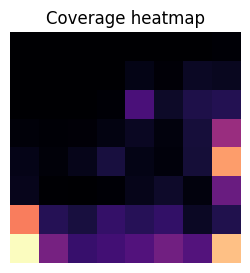

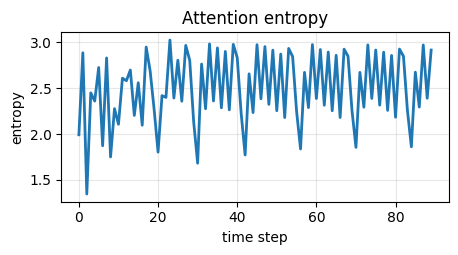

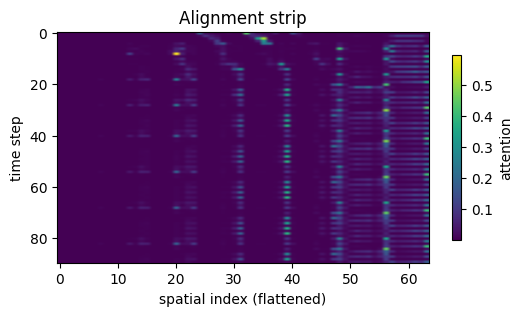

In [12]:

model.eval()
images, tgt, *_ = next(iter(val_loader))
img = images[:1].to(next(model.parameters()).device)

preds, attns = model.generate(img, max_len=tgt.size(1)+10)
attns_one = attns[0]

plot_attention_coverage(attns_one, title="Coverage heatmap", save=f"{SAVE_DIR}/cov.png")
plot_attention_entropy(attns_one,  title="Attention entropy", save=f"{SAVE_DIR}/entropy.png")
plot_alignment_strip(attns_one,    title="Alignment strip",   save=f"{SAVE_DIR}/align.png")


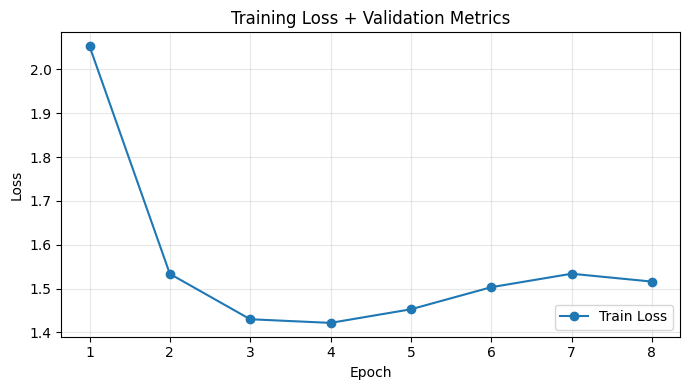

In [1]:
import matplotlib.pyplot as plt

# === fill these manually from your logs ===
epochs     = [1,2,3,4,5,6,7,8]
train_loss = [2.0530, 1.5336, 1.4301, 1.4218, 1.4528, 1.5032, 1.5339, 1.5160]


# === plot ===
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(epochs, train_loss, marker="o", label="Train Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True, alpha=0.3)



# combined legend
lines = ax1.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="lower right")

plt.title("Training Loss + Validation Metrics")
plt.tight_layout()
# optional: save next to your run directory
# SAVE_DIR = "./runs/crohme23_lstm"
# plt.savefig(f"{SAVE_DIR}/manual_curves.png", dpi=200)
plt.show()


In [14]:

import math, json, torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from torchvision import transforms
from PIL import Image

def _ood_transform(severity="mild"):
    if severity == "mild":
        return transforms.Compose([
            transforms.RandomAffine(degrees=3, translate=(0.03,0.03), scale=(0.96,1.04), shear=2),
            #transforms.RandomPerspective(distortion_scale=0.03, p=0.5),
            transforms.ToTensor(), transforms.Normalize([0.5],[0.5]),
        ])
    if severity == "medium":
        return transforms.Compose([
            transforms.RandomAffine(degrees=6, translate=(0.06,0.06), scale=(0.93,1.07), shear=4),
           # transforms.RandomPerspective(distortion_scale=0.08, p=0.8),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
            transforms.ToTensor(), transforms.Normalize([0.5],[0.5]),
        ])
    # strong
    return transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.10,0.10), scale=(0.90,1.10), shear=6),
        #transforms.RandomPerspective(distortion_scale=0.15, p=1.0),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(5, sigma=(0.5, 1.2)),
        transforms.ToTensor(), transforms.Normalize([0.5],[0.5]),
    ])

def _f1_proxy(pred_tokens, gold_tokens):
    p, t = Counter(pred_tokens), Counter(gold_tokens)
    inter = sum((p & t).values())
    prec = inter / max(1, sum(p.values()))
    rec  = inter / max(1, sum(t.values()))
    return 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)

@torch.no_grad()
def evaluate_stress_v2(model, loader, idx2token, eos_idx, pad_idx, device, severity="mild", limit_batches=None):
    tfm = _ood_transform(severity)
    model.eval(); em = 0; f1 = 0.0; n = 0
    for b, (images, tgt, *_ ) in enumerate(loader, start=1):

        imgs = []
        for i in range(images.size(0)):
            arr = (images[i,0].cpu().numpy()*0.5+0.5)  # [0,1]
            arr = (arr*255).astype("uint8")
            imgs.append(tfm(Image.fromarray(arr)))
        images_ood = torch.stack(imgs, dim=0).to(device)

        preds, _ = model.generate(images_ood, max_len=tgt.size(1)+10)
        for i in range(images_ood.size(0)):

            gold_ids = [int(x) for x in tgt[i].tolist() if x not in (pad_idx, eos_idx)]
            if gold_ids and gold_ids[0] == sos_idx: gold_ids = gold_ids[1:]
            gold_tokens = [idx2token[g] for g in gold_ids]
            pred_tokens = [idx2token.get(int(t), "<unk>") for t in preds[i]]

            em += int("".join(pred_tokens).strip() == "".join(gold_tokens).strip())
            f1 += _f1_proxy(pred_tokens, gold_tokens)
            n += 1

        if limit_batches and b >= limit_batches:
            break
    return {"exact_match": em/max(1,n), "bleu": f1/max(1,n), "n": n}  # 'bleu' field contains F1 proxy

@torch.no_grad()
def save_ood_grid(model, loader, idx2token, eos_idx, pad_idx, device, save_path, severity="mild", rows=3, cols=4):
    tfm = _ood_transform(severity)
    images, tgt, *_ = next(iter(loader))
    B = min(images.size(0), rows*cols)


    pil_list = []
    for i in range(B):
        arr = (images[i,0].cpu().numpy()*0.5+0.5)
        arr = (arr*255).astype("uint8")
        pil_list.append(tfm(Image.fromarray(arr)))

    tens = torch.stack(pil_list, dim=0).to(device)
    preds, attns = model.generate(tens, max_len=tgt.size(1)+10)

    import matplotlib.pyplot as plt, numpy as np
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5, rows*3.0))
    axes = np.atleast_2d(axes)
    for i in range(B):
        r,c = divmod(i, cols); ax = axes[r,c]
        ax.imshow(tens[i,0].cpu().numpy()*0.5+0.5, cmap="gray"); ax.axis("off")
        gold_ids = [int(x) for x in tgt[i].tolist() if x not in (pad_idx, eos_idx)]
        if gold_ids and gold_ids[0] == sos_idx: gold_ids = gold_ids[1:]
        gold = "".join([idx2token[g] for g in gold_ids])
        pred = "".join([idx2token.get(int(t), "<unk>") for t in preds[i]])
        ax.set_title(f"GT: {gold}\nPR: {pred}", fontsize=8)
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout(); plt.savefig(save_path, dpi=200); plt.close(fig)
    return save_path


severity = "medium"
metrics = evaluate_stress_v2(model, val_loader, idx2token, eos_idx, pad_idx, device,
                             severity=severity, limit_batches=50)
print(f"Stress ({severity}):", metrics)

grid_path = save_ood_grid(model, val_loader, idx2token, eos_idx, pad_idx, device,
                          save_path=f"{SAVE_DIR}/ood_{severity}_grid.png", severity=severity)
print("Wrote:", grid_path)




Stress (medium): {'exact_match': 0.0, 'bleu': 0.011375360413756364, 'n': 1600}
Wrote: ./runs/crohme23_lstm/ood_medium_grid.png


In [11]:

import os, math, io, json, torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision import transforms


LOAD_BEST_IF_AVAILABLE = True
IMG_SIZE = 256
OUT_DIR = Path(SAVE_DIR) if 'SAVE_DIR' in globals() else Path("./runs/demo")
OUT_DIR.mkdir(parents=True, exist_ok=True)


if "vocab" not in globals():
    # try metadata or checkpoint
    meta_path = Path(globals().get("OUT_ROOT", ".")) / "metadata.json"
    if meta_path.exists():
        with open(meta_path, "r") as f: vocab = json.load(f)["vocab"]
    elif (OUT_DIR/"best.pt").exists():
        ck = torch.load(OUT_DIR/"best.pt", map_location="cpu"); vocab = ck["vocab"]
    else:
        raise RuntimeError("Could not find vocab; run data/splits or training first.")
token2idx = {t:i for i,t in enumerate(vocab)}
idx2token = {i:t for i,t in enumerate(vocab)}
pad_idx = token2idx.get("<pad>", 0)
sos_idx = token2idx.get("<sos>", 1)
eos_idx = token2idx.get("<eos>", 2)


if "model" not in globals():
    model = HMERModel(vocab_size=len(vocab), pad_idx=pad_idx, sos_idx=sos_idx, eos_idx=eos_idx).to(
        torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )
device = next(model.parameters()).device

if LOAD_BEST_IF_AVAILABLE and (OUT_DIR/"best.pt").exists():
    ck = torch.load(OUT_DIR/"best.pt", map_location=device)
    try:
        model.load_state_dict(ck["model"], strict=False)
        print("Loaded weights from:", OUT_DIR/"best.pt")
    except Exception as e:
        print("[WARN] Could not load best.pt:", e)


pre_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
])

def ids_to_tokens(ids):
    out=[]
    for t in ids:
        if t == eos_idx: break
        out.append(idx2token.get(int(t), "<unk>"))
    return out

@torch.no_grad()
def predict_pil(pil_img, max_len=200):
    model.eval()
    img_t = pre_tf(pil_img.convert("L")).unsqueeze(0).to(device)
    preds, attns = model.generate(img_t, max_len=max_len)
    tokens = ids_to_tokens(preds[0])

    cov = None
    if attns and len(attns[0])>0:
        a = torch.stack(attns[0], dim=0).sum(dim=0).cpu().numpy()
        side = int(math.sqrt(a.size))
        cov = a.reshape(side, side) if side*side == a.size else a
    return tokens, img_t.squeeze(0).cpu().numpy(), cov

def show_demo(pil_img, title="Demo"):
    tokens, img_arr, cov = predict_pil(pil_img)
    pred_text = "".join(tokens)


    fig = plt.figure(figsize=(8,3))
    gs = fig.add_gridspec(1, 2, width_ratios=[1,1.2])
    ax1 = fig.add_subplot(gs[0,0]); ax2 = fig.add_subplot(gs[0,1])

    ax1.imshow(img_arr[0]*0.5+0.5, cmap="gray"); ax1.set_title("Input"); ax1.axis("off")
    if cov is not None and cov.ndim == 2:
        ax1.imshow(cov, cmap="jet", alpha=0.35)

    ax2.axis("off")
    ax2.text(0, 0.6, "Predicted LaTeX:", fontsize=11, weight="bold")
    ax2.text(0, 0.35, pred_text, fontsize=14)
    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    out_path = OUT_DIR / "demo_live.png"
    plt.savefig(out_path, dpi=180); plt.show()
    print("Prediction:", pred_text)
    print("Saved figure to:", out_path)


try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    up = widgets.FileUpload(accept=".png,.jpg,.jpeg", multiple=False)
    btn = widgets.Button(description="Run model", button_style="primary")
    out = widgets.Output()

    def _on_click(_):
        with out:
            clear_output(wait=True)
            if len(up.value)==0:
                print("Please upload an image first.")
                return

            k = next(iter(up.value.keys()))
            content = up.value[k]["content"]
            pil = Image.open(io.BytesIO(content)).convert("L")
            show_demo(pil, title=f"Demo: {k}")

    btn.on_click(_on_click)
    display(widgets.VBox([widgets.HTML("<b>Upload an image (PNG/JPG)</b>"), up, btn, out]))
except Exception:

    print("ipywidgets not available. Set IMG_PATH to a local image path and run:")
    print("IMG_PATH = 'path/to/image.png'")
    print("show_demo(Image.open(IMG_PATH))")
